In [1]:
import pandas as pd
import numpy as np
import vertica_python
import os
import seaborn as sns

In [2]:
%matplotlib inline
sns.set_style("darkgrid")
sns.set_context("poster", font_scale=1.2, rc={"lines.linewidth": 2})

In [3]:
username = os.getenv('VERTICA_USERNAME')
password = os.getenv('VERTICA_PASSWORD')
conn_info = {'host': 'warehouse.analytics.edx.org',
             'port': 5433,
             'user': username,
             'password': password,
             'database': 'warehouse',
             'read_timeout': 600,
             'unicode_error': 'strict',
             'ssl': False}

In [55]:
query = """

SELECT
	course_id,
	course_number,
	course_partner,
	course_subject,
	course_start_date,
	course_end_date,
	course_verification_end_date,
	days_between_verification_deadline_and_course_end,
	CASE
		WHEN abs(days_between_verification_deadline_and_course_end) = 0 THEN '0'
		WHEN abs(days_between_verification_deadline_and_course_end) BETWEEN 1 AND 6 THEN '1d-7d'
		WHEN abs(days_between_verification_deadline_and_course_end) BETWEEN 7 AND 13 THEN '7d-14d'
		WHEN abs(days_between_verification_deadline_and_course_end) BETWEEN 14 AND 29 THEN '14d-30d'
		WHEN abs(days_between_verification_deadline_and_course_end) > 29 THEN '>30d'
	END AS days_between_verification_deadline_and_course_end_group,
	MAX(cum_sum_enrolls) AS final_enroll_count, 
	MAX(cum_sum_verifications) AS final_verification_count,
	MAX(vtr) AS final_vtr,
	SUM(
		CASE
			WHEN days_from_verification_deadline = 0 THEN cnt_verifications
			ELSE 0
		END) AS cnt_verifications_final_day,
	SUM(
		CASE
			WHEN days_from_verification_deadline BETWEEN -1 AND 0 THEN cnt_verifications
			ELSE 0
		END) AS cnt_verifications_final_two_days,
	SUM(
		CASE
			WHEN days_from_verification_deadline BETWEEN -2 AND 0 THEN cnt_verifications
			ELSE 0
		END) AS cnt_verifications_final_three_day,
	SUM(
		CASE
			WHEN days_from_verification_deadline BETWEEN -6 AND 0 THEN cnt_verifications
			ELSE 0
		END) AS cnt_verifications_final_seven_day

FROM
(
	SELECT
		a.course_id,
		a.course_number,
		course_partner,
		course_subject,
		course_start_date,
		course_end_date,
		course_verification_end_date,
		DATEDIFF('day', course_end_date, course_verification_end_date) AS days_between_verification_deadline_and_course_end,
		DATEDIFF('day', course_verification_end_date, b.date) AS days_from_verification_deadline,
		cnt_verifications,
		cum_sum_verifications,
		cnt_enrolls,
		cum_sum_enrolls,
		cum_sum_course_vtr * 100.0 AS vtr
	FROM 
		business_intelligence.course_master a
	JOIN 
		business_intelligence.course_stats_time b
	ON 
		a.course_id = b.course_id
	AND 
		course_end_date is not null
	AND 
		course_verification_end_Date is not null
	AND 
		pacing_type = 'instructor_paced'
	AND 
		b.date BETWEEN DATE(course_verification_end_date) - 7 AND DATE(course_verification_end_date)
) a
GROUP BY
	course_id,
	course_number,
	course_partner,
	course_subject,
	course_start_date,
	course_end_date,
	course_verification_end_date,
	days_between_verification_deadline_and_course_end,
	8

"""

In [56]:
connection = vertica_python.connect(**conn_info)

cur = connection.cursor('dict')

cur.execute(query)
extract = cur.fetchall()
df = pd.DataFrame(extract)

connection.close()

### Clean Clean Clean

In [111]:
df['pct_verifs_final_day'] = df['cnt_verifications_final_day']*100.0/df['final_verification_count']

df['pct_verifs_final_two_day'] = df['cnt_verifications_final_two_days']*100.0/df['final_verification_count']

df['pct_verifs_final_three_day'] = df['cnt_verifications_final_three_day']*100.0/df['final_verification_count']

df['pct_verifs_final_seven_day'] = df['cnt_verifications_final_seven_day']*100.0/df['final_verification_count']

df = df[
   (df.days_between_verification_deadline_and_course_end <= 0) &
    (df.days_between_verification_deadline_and_course_end > -90)
    ]

df['final_vtr'] = df.final_vtr.astype(float)

df_filtered = df

/Users/adleyhemphill/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [112]:
plot_order = [  
    '0',
    '1d-7d',
    '7d-14d',
    '14d-30d',
    '>30d'
]

In [113]:
df_multiple_course_runs = df_filtered.groupby(['course_number']).count()['course_id'][df_filtered.groupby(['course_number']).count()['course_id']>1]
df_multiple_course_runs_list = df_multiple_course_runs.reset_index()['course_number']
df_filtered_multiple_course_runs = df_filtered[df_filtered['course_number'].isin(df_multiple_course_runs_list)]

## Check out the distribution of verification end dates to see where to bucket

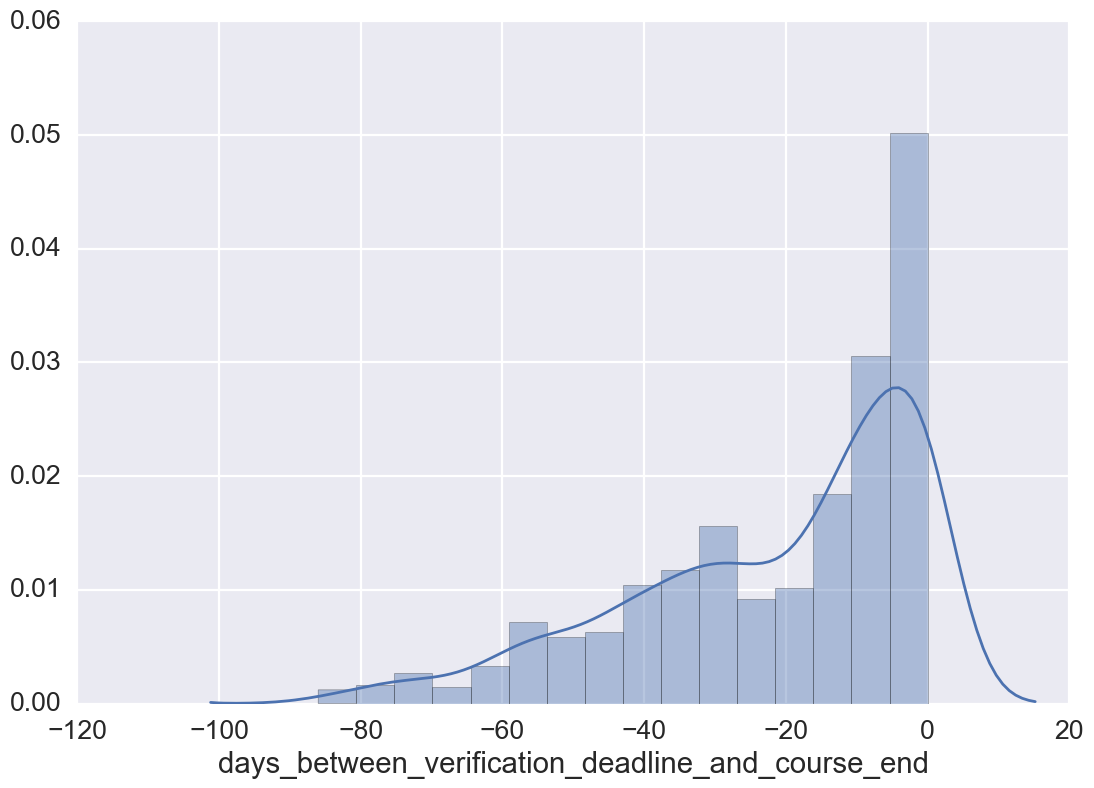

In [114]:
sns.distplot(
    df_filtered.days_between_verification_deadline_and_course_end
)

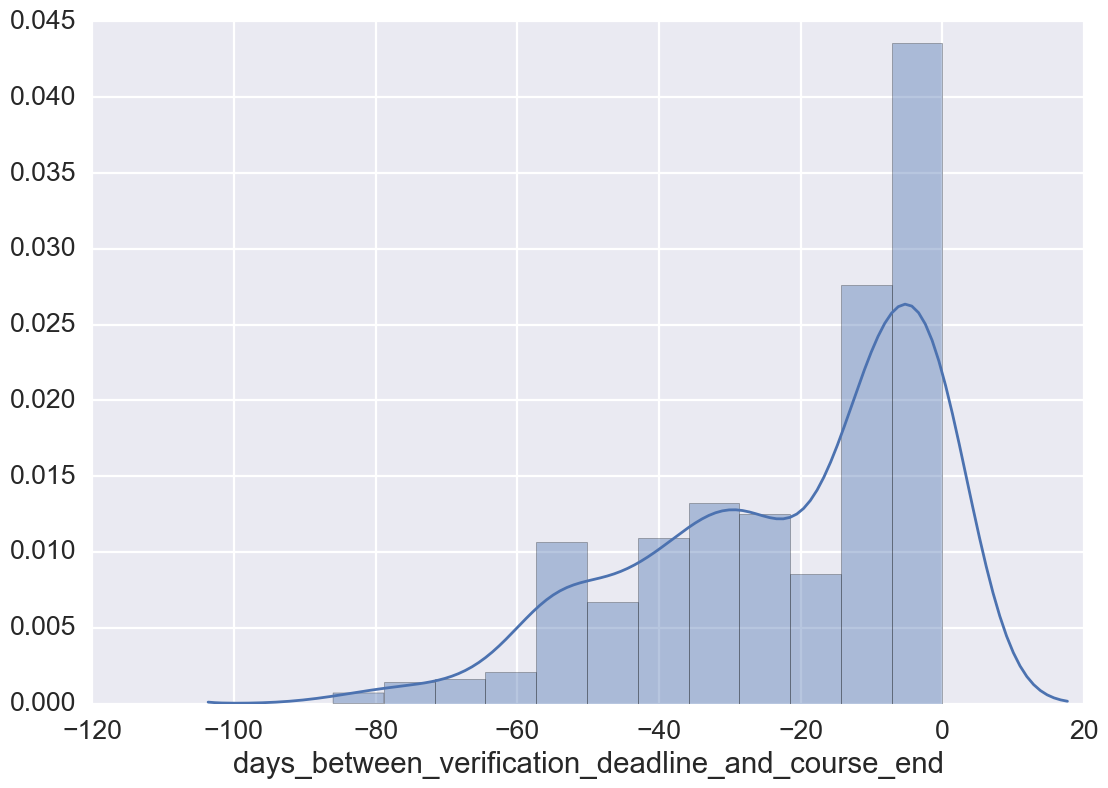

In [115]:
sns.distplot(
    df_filtered_multiple_course_runs.days_between_verification_deadline_and_course_end
)

In [44]:
# g = sns.FacetGrid(df_filtered, 
#                   row="days_between_verification_deadline_and_course_end_group", row_order = plot_order,
#                   size=10,)
# g.map(sns.distplot, "final_vtr", rug=True);

In [18]:
# sns.lmplot(
#     data = df_filtered[df_filtered.final_enroll_count > 10000],
#     x = 'days_between_verification_deadline_and_course_end',
#     y = 'final_vtr',
#     #hue = 'course_subject',
#     size = 10
# )

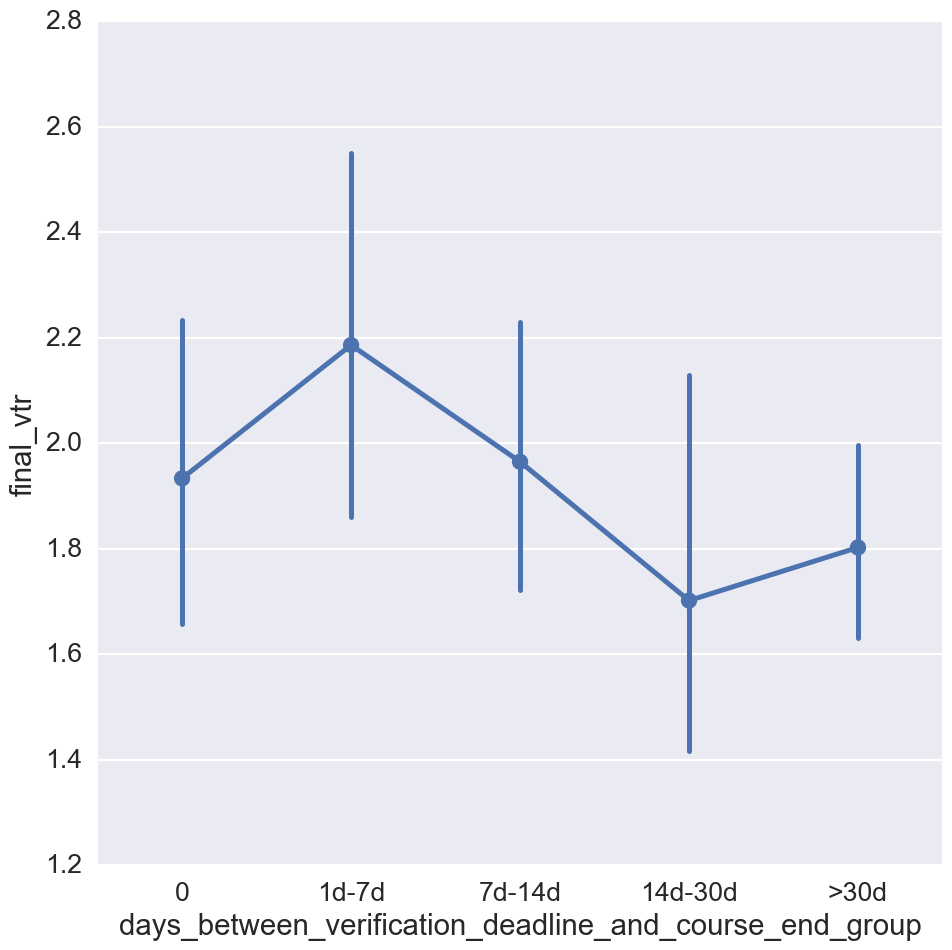

In [116]:
ax = sns.factorplot(
    data = df_filtered[
        (df_filtered.course_partner!='Microsoft') &
        (df_filtered.final_enroll_count > 1000)
    ],
    x = 'days_between_verification_deadline_and_course_end_group',
    y = 'final_vtr',
    order = plot_order,
    size = 10,
    kind = 'point'
)
#ax.set(ylim = (0,10))

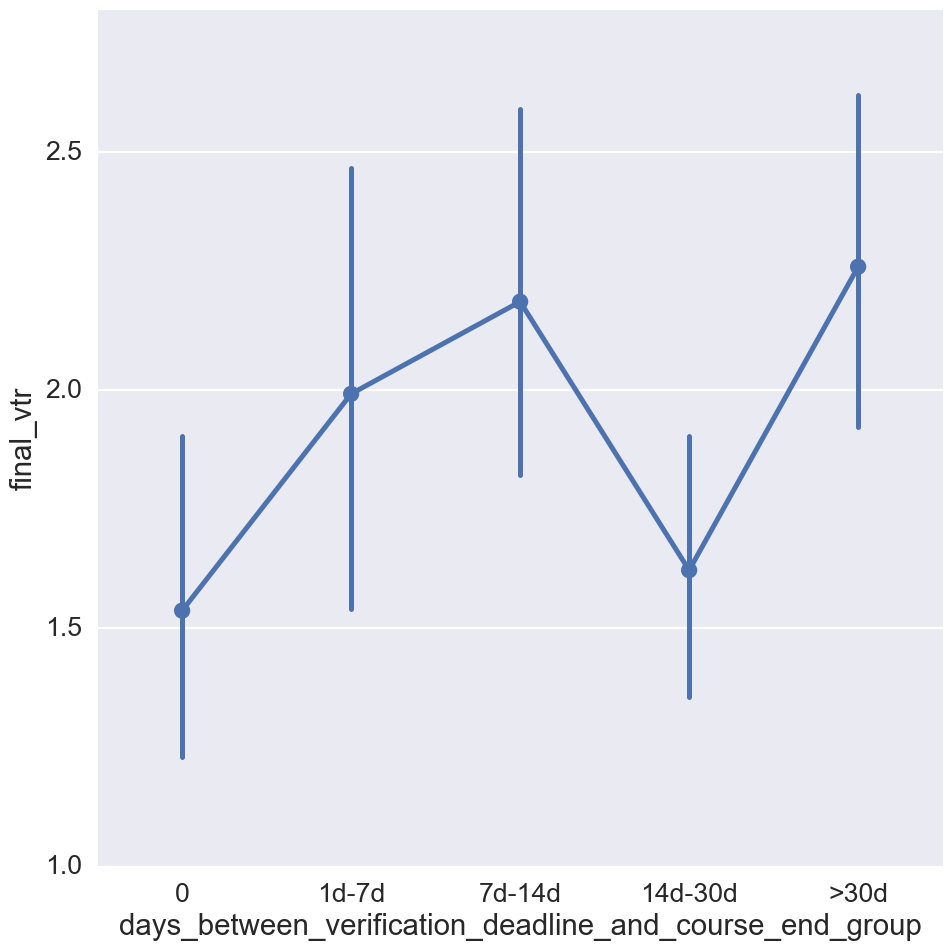

In [117]:
ax = sns.factorplot(
    data = df_filtered_multiple_course_runs[
        (df_filtered_multiple_course_runs.course_partner!='Microsoft') &
        (df_filtered_multiple_course_runs.final_enroll_count > 1000)
    ],
    x = 'days_between_verification_deadline_and_course_end_group',
    y = 'final_vtr',
    order = plot_order,
    size = 10,
    kind = 'point'
)
#ax.set(ylim = (0,10))

In [99]:
df_filtered_multiple_course_runs[df_filtered_multiple_course_runs.course_number == 'UQx+Write101x']

,course_id,course_number,course_partner,course_subject,course_start_date,course_end_date,course_verification_end_date,days_between_verification_deadline_and_course_end,days_between_verification_deadline_and_course_end_group,final_enroll_count,final_verification_count,final_vtr,cnt_verifications_final_day,cnt_verifications_final_two_days,cnt_verifications_final_three_day,cnt_verifications_final_seven_day,pct_verifs_final_day,pct_verifs_final_two_day,pct_verifs_final_three_day,pct_verifs_final_seven_day
0,course-v1:UQx+Write101x+1T2016,UQx+Write101x,UQx,None,2016-02-29,2016-05-01,2016-04-17,-14,14d-30d,55148.0,120.0,0.217596,4.0,6.0,9.0,18.0,3.333333,5.000000,7.500000,15.000000
78,course-v1:UQx+Write101x+2T2015,UQx+Write101x,UQx,None,2015-07-26,2015-09-27,2015-09-13,-14,14d-30d,101899.0,236.0,0.231602,5.0,9.0,12.0,16.0,2.118644,3.813559,5.084746,6.779661
742,course-v1:UQx+Write101x+1T2017,UQx+Write101x,UQx,None,2017-02-27,2017-05-01,2017-05-01,0,0,89040.0,293.0,0.329088,4.0,8.0,12.0,14.0,1.365188,2.730375,4.095563,4.778157
948,UQx/Write101x/3T2014,UQx+Write101x,UQx,None,2014-09-22,2014-11-16,2014-10-07,-40,>30d,48062.0,113.0,0.236600,0.0,0.0,2.0,9.0,0.000000,0.000000,1.769912,7.964602
1230,course-v1:UQx+Write101x+2T2016,UQx+Write101x,UQx,None,2016-07-25,2016-09-26,2016-09-26,0,0,104064.0,239.0,0.229666,5.0,8.0,8.0,17.0,2.092050,3.347280,3.347280,7.112971


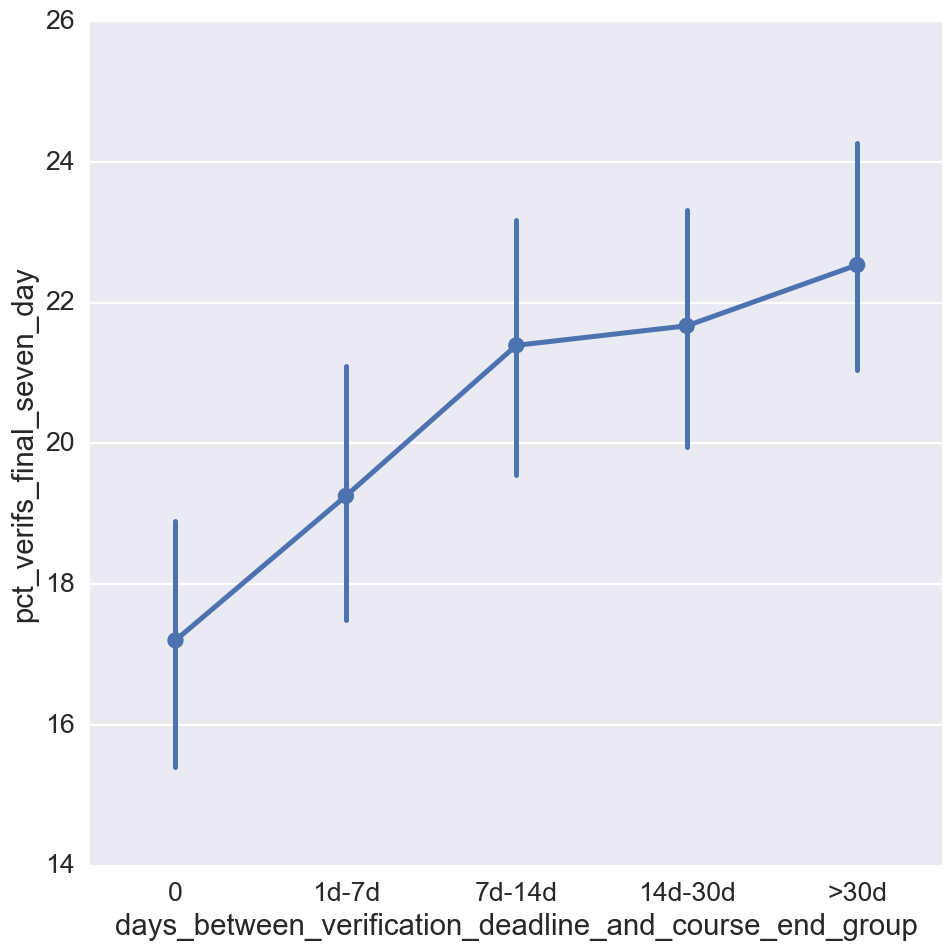

In [22]:
sns.factorplot(
    data = df_filtered,
    x = 'days_between_verification_deadline_and_course_end_group',
    y = 'pct_verifs_final_seven_day',
    order = plot_order,
    size = 10
)

## feature importance

In [122]:
from tpot import TPOTRegressor, TPOTClassifier
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.model_selection import train_test_split

In [120]:
rf = RandomForestClassifier(n_estimators = 100)


In [128]:
y = df_filtered['final_vtr']
X = pd.get_dummies(df_filtered[
    ['course_subject','course_partner','days_between_verification_deadline_and_course_end_group']
])

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.75)

In [130]:
rf.fit(X_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').